In [162]:
using DIVAnd
using Dates
using NCDatasets
using Test
using PyPlot
using Statistics
using DelimitedFiles
const plt = PyPlot
include("./ME4OH.jl")
include("./config.jl")

[ Info: File already downloaded


In [160]:
datadir = "/home/ctroupin/data/ME4OH/data/en4.1.1/1979-2014/full/update/extra/"
datafilelist = ME4OH.get_filelist(datadirextra, timeperiod1)

lenall = Array{Float64}(undef, length(datafilelist), 3)

for (iii, datafile) in enumerate(datafilelist)
    lon, lat, dates, vertical_levels, T, S, dohc, dohc_mask, bounds = ME4OH.read_profile(datafile)
    obslon, obslat, obsdepth, obsdates, obsval = 
    ME4OH.vectorize_dohc(lon, lat, bounds, dates, dohc, dohc_mask);
    
    # Perform fit to get idea of the best correlation length (changing by level)
    lenxy, dbinfo = DIVAnd.fithorzlen((obslon, obslat, obsdepth), obsval, bounds[:,2]);
    lenall[iii,:] = lenxy;
end

[ Info: Found 5285 out of 26343 values
[ Info: Data points at z=286.60898: 3898, horz. correlation length: 11.342904369215859 (preliminary)
[ Info: Data points at z=685.92676: 1124, horz. correlation length: 5.107934527510025 (preliminary)
[ Info: Data points at z=1985.3134: 263, horz. correlation length: 39.45534842475124 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.0829710953293
[ Info: Smoothed horz. correlation length at z=685.92676: 8.125298157813587
[ Info: Smoothed horz. correlation length at z=1985.3134: 37.512874215655
[ Info: Found 6279 out of 30789 values
[ Info: Data points at z=286.60898: 4822, horz. correlation length: 13.064234897741278 (preliminary)
[ Info: Data points at z=685.92676: 1185, horz. correlation length: 20.787701899882567 (preliminary)
[ Info: Data points at z=1985.3134: 272, horz. correlation length: 27.40215921801397 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 16.247119491975493
[ Info: Smoothed hor

[ Info: Data points at z=286.60898: 4710, horz. correlation length: 14.711396304000015 (preliminary)
┌ Warning: Too few data. Will use guesses (np = 8, RLz = 14.114049829509604, )
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/fit.jl:648
[ Info: Data points at z=685.92676: 976, horz. correlation length: 14.114049829509604 (preliminary)
[ Info: Data points at z=1985.3134: 180, horz. correlation length: 8.750196287450906 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.64966551199432
[ Info: Smoothed horz. correlation length at z=685.92676: 13.55504221527982
[ Info: Smoothed horz. correlation length at z=1985.3134: 8.775367167717395
[ Info: Found 4884 out of 20460 values
[ Info: Data points at z=286.60898: 3690, horz. correlation length: 14.116274977231 (preliminary)
[ Info: Data points at z=685.92676: 958, horz. correlation length: 18.978046811670207 (preliminary)
[ Info: Data points at z=1985.3134: 236, horz. correlation length: 5.212005089154645 (preliminary)


[ Info: Data points at z=286.60898: 5390, horz. correlation length: 13.227601426626524 (preliminary)
[ Info: Data points at z=685.92676: 1277, horz. correlation length: 4.101964342180458 (preliminary)
[ Info: Data points at z=1985.3134: 225, horz. correlation length: 26.860708998342513 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.557254994548394
[ Info: Smoothed horz. correlation length at z=685.92676: 7.008508066501928
[ Info: Smoothed horz. correlation length at z=1985.3134: 25.631951950565576
[ Info: Found 6244 out of 30411 values
[ Info: Data points at z=286.60898: 4902, horz. correlation length: 8.25631099579885 (preliminary)
[ Info: Data points at z=685.92676: 1123, horz. correlation length: 4.726823321687851 (preliminary)
[ Info: Data points at z=1985.3134: 219, horz. correlation length: 108.4829706633067 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 7.421074330781215
[ Info: Smoothed horz. correlation length at z=685.92676:

[ Info: Data points at z=286.60898: 5431, horz. correlation length: 13.40521906467557 (preliminary)
[ Info: Data points at z=685.92676: 1200, horz. correlation length: 5.978773305020848 (preliminary)
[ Info: Data points at z=1985.3134: 412, horz. correlation length: 13.76652320298155 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 10.40468293669672
[ Info: Smoothed horz. correlation length at z=685.92676: 7.825339587234858
[ Info: Smoothed horz. correlation length at z=1985.3134: 13.396318395013363
[ Info: Found 6830 out of 28041 values
[ Info: Data points at z=286.60898: 4855, horz. correlation length: 10.654470734273897 (preliminary)
[ Info: Data points at z=685.92676: 1428, horz. correlation length: 11.567318425150592 (preliminary)
[ Info: Data points at z=1985.3134: 547, horz. correlation length: 134.03921002564203 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.696807077591863
[ Info: Smoothed horz. correlation length at z=685.926

[ Info: Data points at z=286.60898: 6276, horz. correlation length: 11.302444609369962 (preliminary)
[ Info: Data points at z=685.92676: 1355, horz. correlation length: 6.637007902230154 (preliminary)
[ Info: Data points at z=1985.3134: 207, horz. correlation length: 8.041648048739951 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.567776125033355
[ Info: Smoothed horz. correlation length at z=685.92676: 7.706596936553092
[ Info: Smoothed horz. correlation length at z=1985.3134: 7.989707138610965
[ Info: Found 8408 out of 33255 values
[ Info: Data points at z=286.60898: 6060, horz. correlation length: 11.95369724195448 (preliminary)
[ Info: Data points at z=685.92676: 1959, horz. correlation length: 10.22322190563023 (preliminary)
[ Info: Data points at z=1985.3134: 389, horz. correlation length: 9.510592363427342 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.335749152365082
[ Info: Smoothed horz. correlation length at z=685.92676:

[ Info: Data points at z=286.60898: 6185, horz. correlation length: 12.743840909680241 (preliminary)
[ Info: Data points at z=685.92676: 1496, horz. correlation length: 4.634480374137335 (preliminary)
[ Info: Data points at z=1985.3134: 386, horz. correlation length: 102.69914211650224 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 10.064183667724487
[ Info: Smoothed horz. correlation length at z=685.92676: 10.570714108842845
[ Info: Smoothed horz. correlation length at z=1985.3134: 96.09803094706557
[ Info: Found 7352 out of 33516 values
[ Info: Data points at z=286.60898: 6013, horz. correlation length: 13.139976511512973 (preliminary)
[ Info: Data points at z=685.92676: 1136, horz. correlation length: 3.9204468511093835 (preliminary)
[ Info: Data points at z=1985.3134: 203, horz. correlation length: 4.014682162234502 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.371504198032136
[ Info: Smoothed horz. correlation length at z=685.92

[ Info: Data points at z=286.60898: 4728, horz. correlation length: 14.973470103015508 (preliminary)
[ Info: Data points at z=685.92676: 1658, horz. correlation length: 15.59062332726108 (preliminary)
[ Info: Data points at z=1985.3134: 353, horz. correlation length: 19.158871645337776 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.241689751134519
[ Info: Smoothed horz. correlation length at z=685.92676: 15.67487555531237
[ Info: Smoothed horz. correlation length at z=1985.3134: 18.97366877695472
[ Info: Found 8593 out of 33585 values
[ Info: Data points at z=286.60898: 6290, horz. correlation length: 17.000666393806302 (preliminary)
[ Info: Data points at z=685.92676: 1809, horz. correlation length: 16.782811820786282 (preliminary)
[ Info: Data points at z=1985.3134: 494, horz. correlation length: 19.04699552699026 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 16.94066004326896
[ Info: Smoothed horz. correlation length at z=685.926

[ Info: Data points at z=286.60898: 6627, horz. correlation length: 13.078453666338143 (preliminary)
[ Info: Data points at z=685.92676: 2020, horz. correlation length: 12.831772988043653 (preliminary)
[ Info: Data points at z=1985.3134: 461, horz. correlation length: 9.432597380405253 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.948399803062587
[ Info: Smoothed horz. correlation length at z=685.92676: 12.658667912881464
[ Info: Smoothed horz. correlation length at z=1985.3134: 9.591677121282801
[ Info: Found 5272 out of 22824 values
[ Info: Data points at z=286.60898: 3730, horz. correlation length: 10.475742734390408 (preliminary)
[ Info: Data points at z=685.92676: 1257, horz. correlation length: 10.086894296122072 (preliminary)
[ Info: Data points at z=1985.3134: 285, horz. correlation length: 60.43587510799577 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 10.609620776441428
[ Info: Smoothed horz. correlation length at z=685.9

[ Info: Data points at z=286.60898: 6243, horz. correlation length: 12.92456433369231 (preliminary)
[ Info: Data points at z=685.92676: 1615, horz. correlation length: 4.183115685247669 (preliminary)
[ Info: Data points at z=1985.3134: 312, horz. correlation length: 66.17051681888239 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.765857189421611
[ Info: Smoothed horz. correlation length at z=685.92676: 8.806184900201945
[ Info: Smoothed horz. correlation length at z=1985.3134: 62.27601201304687
[ Info: Found 9497 out of 42318 values
[ Info: Data points at z=286.60898: 7214, horz. correlation length: 14.732847355876839 (preliminary)
[ Info: Data points at z=685.92676: 2049, horz. correlation length: 6.078190748702111 (preliminary)
[ Info: Data points at z=1985.3134: 234, horz. correlation length: 7.0727489239724415 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.154606009448315
[ Info: Smoothed horz. correlation length at z=685.92676

[ Info: Data points at z=286.60898: 6152, horz. correlation length: 12.375851875175844 (preliminary)
[ Info: Data points at z=685.92676: 1556, horz. correlation length: 5.003040850173265 (preliminary)
[ Info: Data points at z=1985.3134: 500, horz. correlation length: 12.368219558809647 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.492532553495566
[ Info: Smoothed horz. correlation length at z=685.92676: 6.893557686731375
[ Info: Smoothed horz. correlation length at z=1985.3134: 12.039128910968149
[ Info: Found 9197 out of 44724 values
[ Info: Data points at z=286.60898: 6903, horz. correlation length: 10.778289454633967 (preliminary)
[ Info: Data points at z=685.92676: 1885, horz. correlation length: 5.928400562047211 (preliminary)
[ Info: Data points at z=1985.3134: 409, horz. correlation length: 9.161509348716379 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 8.849710368038334
[ Info: Smoothed horz. correlation length at z=685.9267

[ Info: Data points at z=286.60898: 8606, horz. correlation length: 10.989182180799354 (preliminary)
[ Info: Data points at z=685.92676: 1998, horz. correlation length: 5.857220504026888 (preliminary)
[ Info: Data points at z=1985.3134: 315, horz. correlation length: 10.387104967602191 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 8.94084971464713
[ Info: Smoothed horz. correlation length at z=685.92676: 7.109696556872761
[ Info: Smoothed horz. correlation length at z=1985.3134: 10.182797450275865
[ Info: Found 10329 out of 43416 values
[ Info: Data points at z=286.60898: 7632, horz. correlation length: 12.642397937028845 (preliminary)
┌ Warning: Too few data. Will use guesses (np = 9, RLz = 15.653649402979092, )
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/fit.jl:648
[ Info: Data points at z=685.92676: 2206, horz. correlation length: 15.653649402979092 (preliminary)
[ Info: Data points at z=1985.3134: 491, horz. correlation length: 178.42174492269396 (prelim

[ Info: Data points at z=685.92676: 1700, horz. correlation length: 17.495624414277252 (preliminary)
[ Info: Data points at z=1985.3134: 418, horz. correlation length: 18.97712201263816 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 21.35992711657678
[ Info: Smoothed horz. correlation length at z=685.92676: 20.746406609657612
[ Info: Smoothed horz. correlation length at z=1985.3134: 18.983811054080356
[ Info: Found 9447 out of 34407 values
[ Info: Data points at z=286.60898: 6944, horz. correlation length: 11.270344002581059 (preliminary)
[ Info: Data points at z=685.92676: 1928, horz. correlation length: 7.6054668553070455 (preliminary)
[ Info: Data points at z=1985.3134: 575, horz. correlation length: 8.860108337427937 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.875048977664767
[ Info: Smoothed horz. correlation length at z=685.92676: 8.432086822235844
[ Info: Smoothed horz. correlation length at z=1985.3134: 8.812124765613184
[ 

[ Info: Data points at z=1985.3134: 255, horz. correlation length: 116.62488556327389 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.436439668371523
[ Info: Smoothed horz. correlation length at z=685.92676: 18.107637114688167
[ Info: Smoothed horz. correlation length at z=1985.3134: 108.42665570213752
[ Info: Found 5556 out of 22530 values
[ Info: Data points at z=286.60898: 4137, horz. correlation length: 9.908302597681182 (preliminary)
[ Info: Data points at z=685.92676: 1069, horz. correlation length: 8.744806092590583 (preliminary)
[ Info: Data points at z=1985.3134: 350, horz. correlation length: 8.771691884370735 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.451254737190299
[ Info: Smoothed horz. correlation length at z=685.92676: 8.977055977874896
[ Info: Smoothed horz. correlation length at z=1985.3134: 8.77408771720652
[ Info: Found 6984 out of 26958 values
[ Info: Data points at z=286.60898: 5032, horz. correlation lengt

[ Info: Data points at z=1985.3134: 555, horz. correlation length: 8.206863806502653 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 10.239324947065189
[ Info: Smoothed horz. correlation length at z=685.92676: 8.462724325582462
[ Info: Smoothed horz. correlation length at z=1985.3134: 8.189148409725254
[ Info: Found 6868 out of 28089 values
[ Info: Data points at z=286.60898: 4982, horz. correlation length: 15.655622663487247 (preliminary)
[ Info: Data points at z=685.92676: 1623, horz. correlation length: 4.799524509165002 (preliminary)
[ Info: Data points at z=1985.3134: 263, horz. correlation length: 11.970360811252405 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.311812552937681
[ Info: Smoothed horz. correlation length at z=685.92676: 7.268284109639583
[ Info: Smoothed horz. correlation length at z=1985.3134: 11.612064164516179
[ Info: Found 5252 out of 21324 values
[ Info: Data points at z=286.60898: 3867, horz. correlation len

[ Info: Data points at z=286.60898: 6590, horz. correlation length: 9.301317760208681 (preliminary)
[ Info: Data points at z=685.92676: 1943, horz. correlation length: 5.173688957522976 (preliminary)
[ Info: Data points at z=1985.3134: 266, horz. correlation length: 5.2832513502301355 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 7.607809373794884
[ Info: Smoothed horz. correlation length at z=685.92676: 5.950066755396275
[ Info: Smoothed horz. correlation length at z=1985.3134: 5.289760152613806
[ Info: Found 10668 out of 37725 values
[ Info: Data points at z=286.60898: 8018, horz. correlation length: 12.615868028397923 (preliminary)
[ Info: Data points at z=685.92676: 2364, horz. correlation length: 4.463522411996603 (preliminary)
[ Info: Data points at z=1985.3134: 286, horz. correlation length: 3.983724644230242 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.249902252834149
[ Info: Smoothed horz. correlation length at z=685.92676

[ Info: Data points at z=286.60898: 7036, horz. correlation length: 14.504730036663354 (preliminary)
[ Info: Data points at z=685.92676: 2263, horz. correlation length: 8.865737006783336 (preliminary)
[ Info: Data points at z=1985.3134: 259, horz. correlation length: 19.727705450483235 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.178158298460955
[ Info: Smoothed horz. correlation length at z=685.92676: 10.473105994889115
[ Info: Smoothed horz. correlation length at z=1985.3134: 19.152728257588763
[ Info: Found 9263 out of 30579 values
[ Info: Data points at z=286.60898: 6376, horz. correlation length: 12.825321686172757 (preliminary)
[ Info: Data points at z=685.92676: 2584, horz. correlation length: 7.368889648973009 (preliminary)
[ Info: Data points at z=1985.3134: 303, horz. correlation length: 39.412248713069644 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 10.561794689749288
[ Info: Smoothed horz. correlation length at z=685.

[ Info: Data points at z=286.60898: 6332, horz. correlation length: 14.225847104186332 (preliminary)
[ Info: Data points at z=685.92676: 2433, horz. correlation length: 17.328982536126503 (preliminary)
[ Info: Data points at z=1985.3134: 232, horz. correlation length: 41.320422229697286 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.649652290887033
[ Info: Smoothed horz. correlation length at z=685.92676: 18.175665493257316
[ Info: Smoothed horz. correlation length at z=1985.3134: 40.12399007606649
[ Info: Found 11544 out of 37035 values
[ Info: Data points at z=286.60898: 7982, horz. correlation length: 15.663939909560042 (preliminary)
[ Info: Data points at z=685.92676: 3071, horz. correlation length: 12.93173126205378 (preliminary)
[ Info: Data points at z=1985.3134: 491, horz. correlation length: 47.929589199683434 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.773220487474775
[ Info: Smoothed horz. correlation length at z=685

[ Info: Data points at z=286.60898: 7305, horz. correlation length: 19.481345124178805 (preliminary)
[ Info: Data points at z=685.92676: 3237, horz. correlation length: 6.208063588333381 (preliminary)
[ Info: Data points at z=1985.3134: 269, horz. correlation length: 17.943116985279396 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.944121788404587
[ Info: Smoothed horz. correlation length at z=685.92676: 9.170778763257102
[ Info: Smoothed horz. correlation length at z=1985.3134: 17.241012819754182
[ Info: Found 10615 out of 29961 values
[ Info: Data points at z=286.60898: 7208, horz. correlation length: 17.48557422088599 (preliminary)
[ Info: Data points at z=685.92676: 3056, horz. correlation length: 7.699259360648546 (preliminary)
[ Info: Data points at z=1985.3134: 351, horz. correlation length: 3.7371005608746586 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.893315825607985
[ Info: Smoothed horz. correlation length at z=685.9

[ Info: Data points at z=286.60898: 6056, horz. correlation length: 14.8421384045325 (preliminary)
[ Info: Data points at z=685.92676: 2749, horz. correlation length: 9.528371303493614 (preliminary)
[ Info: Data points at z=1985.3134: 87, horz. correlation length: 38.30357575274835 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.863356772169483
[ Info: Smoothed horz. correlation length at z=685.92676: 12.070679716916795
[ Info: Smoothed horz. correlation length at z=1985.3134: 36.7023312991011
[ Info: Found 9806 out of 25803 values
[ Info: Data points at z=286.60898: 6565, horz. correlation length: 19.384173698953035 (preliminary)
[ Info: Data points at z=685.92676: 2967, horz. correlation length: 12.503308222388972 (preliminary)
[ Info: Data points at z=1985.3134: 274, horz. correlation length: 6.138407284622616 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 16.45153762632673
[ Info: Smoothed horz. correlation length at z=685.92676: 

[ Info: Data points at z=286.60898: 7119, horz. correlation length: 18.437500145375427 (preliminary)
[ Info: Data points at z=685.92676: 2949, horz. correlation length: 15.549722242554092 (preliminary)
[ Info: Data points at z=1985.3134: 228, horz. correlation length: 32.30929777544277 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 17.305973092648966
[ Info: Smoothed horz. correlation length at z=685.92676: 17.048868799119756
[ Info: Smoothed horz. correlation length at z=1985.3134: 31.46509666065634
[ Info: Found 11680 out of 32628 values
[ Info: Data points at z=286.60898: 8107, horz. correlation length: 17.817211588640404 (preliminary)
[ Info: Data points at z=685.92676: 3281, horz. correlation length: 6.945284837362988 (preliminary)
[ Info: Data points at z=1985.3134: 292, horz. correlation length: 14.143240701196333 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.126016329753162
[ Info: Smoothed horz. correlation length at z=685.

[ Info: Data points at z=286.60898: 8635, horz. correlation length: 12.450786836333371 (preliminary)
[ Info: Data points at z=685.92676: 3879, horz. correlation length: 15.120228941058533 (preliminary)
[ Info: Data points at z=1985.3134: 326, horz. correlation length: 113.71426319230085 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.532574049241589
[ Info: Smoothed horz. correlation length at z=685.92676: 14.588548429160598
[ Info: Smoothed horz. correlation length at z=1985.3134: 14.960110206091299
[ Info: Found 11172 out of 35463 values
[ Info: Data points at z=286.60898: 7673, horz. correlation length: 16.963325672989345 (preliminary)
[ Info: Data points at z=685.92676: 3189, horz. correlation length: 18.143712669641893 (preliminary)
[ Info: Data points at z=1985.3134: 310, horz. correlation length: 22.646457084158985 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 17.51237920407942
[ Info: Smoothed horz. correlation length at z=68

[ Info: Data points at z=286.60898: 7598, horz. correlation length: 18.172411892132253 (preliminary)
[ Info: Data points at z=685.92676: 3057, horz. correlation length: 12.372253744863466 (preliminary)
[ Info: Data points at z=1985.3134: 345, horz. correlation length: 21.38533722549282 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.82887750484759
[ Info: Smoothed horz. correlation length at z=685.92676: 14.022780253466298
[ Info: Smoothed horz. correlation length at z=1985.3134: 20.989934407642856
[ Info: Found 9622 out of 30729 values
[ Info: Data points at z=286.60898: 6659, horz. correlation length: 14.639965102565654 (preliminary)
[ Info: Data points at z=685.92676: 2691, horz. correlation length: 7.0409039546900285 (preliminary)
[ Info: Data points at z=1985.3134: 272, horz. correlation length: 7.117285659360903 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.454031843653489
[ Info: Smoothed horz. correlation length at z=685.9

[ Info: Data points at z=286.60898: 7031, horz. correlation length: 14.221572910473691 (preliminary)
[ Info: Data points at z=685.92676: 3537, horz. correlation length: 5.333869667706068 (preliminary)
[ Info: Data points at z=1985.3134: 142, horz. correlation length: 10.471729137218077 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 10.592044832269162
[ Info: Smoothed horz. correlation length at z=685.92676: 7.253398432752376
[ Info: Smoothed horz. correlation length at z=1985.3134: 10.188785599675642
[ Info: Found 10746 out of 31113 values
[ Info: Data points at z=286.60898: 7085, horz. correlation length: 16.985862093699442 (preliminary)
[ Info: Data points at z=685.92676: 3427, horz. correlation length: 8.14821878192674 (preliminary)
[ Info: Data points at z=1985.3134: 234, horz. correlation length: 11.368462625891222 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.614123604776653
[ Info: Smoothed horz. correlation length at z=685.9

[ Info: Data points at z=286.60898: 6581, horz. correlation length: 14.213582703374682 (preliminary)
[ Info: Data points at z=685.92676: 2883, horz. correlation length: 7.545150324947604 (preliminary)
[ Info: Data points at z=1985.3134: 232, horz. correlation length: 98.21868792020763 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.027592419777774
[ Info: Smoothed horz. correlation length at z=685.92676: 12.73996463806739
[ Info: Smoothed horz. correlation length at z=1985.3134: 91.92134664534541
[ Info: Found 10732 out of 30243 values
[ Info: Data points at z=286.60898: 7238, horz. correlation length: 13.440114158031848 (preliminary)
[ Info: Data points at z=685.92676: 3376, horz. correlation length: 7.854520527579526 (preliminary)
[ Info: Data points at z=1985.3134: 118, horz. correlation length: 8.120703348934939 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.221982480579326
[ Info: Smoothed horz. correlation length at z=685.926

[ Info: Data points at z=286.60898: 6754, horz. correlation length: 12.436363075134867 (preliminary)
[ Info: Data points at z=685.92676: 3597, horz. correlation length: 6.152607371443452 (preliminary)
┌ Warning: Too few data. Will use guesses (np = 4, RLz = 11.254988554760374, )
└ @ DIVAnd ~/.julia/packages/DIVAnd/BQFGA/src/fit.jl:648
[ Info: Data points at z=1985.3134: 54, horz. correlation length: 11.254988554760374 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 9.931558443594966
[ Info: Smoothed horz. correlation length at z=685.92676: 7.4320459721282335
[ Info: Smoothed horz. correlation length at z=1985.3134: 6.539421135202425
[ Info: Found 11398 out of 28461 values
[ Info: Data points at z=286.60898: 7363, horz. correlation length: 14.49198003415409 (preliminary)
[ Info: Data points at z=685.92676: 3919, horz. correlation length: 7.925212364033607 (preliminary)
[ Info: Data points at z=1985.3134: 116, horz. correlation length: 2.305043883337093 (prelimina

[ Info: Data points at z=1985.3134: 98, horz. correlation length: 5.714844082261432 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.253836913142894
[ Info: Smoothed horz. correlation length at z=685.92676: 13.521688851021825
[ Info: Smoothed horz. correlation length at z=1985.3134: 6.15451015767986
[ Info: Found 12904 out of 36162 values
[ Info: Data points at z=286.60898: 8348, horz. correlation length: 17.5227527556841 (preliminary)
[ Info: Data points at z=685.92676: 4243, horz. correlation length: 9.476899415133758 (preliminary)
[ Info: Data points at z=1985.3134: 313, horz. correlation length: 2.37078841637535 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.854180582177197
[ Info: Smoothed horz. correlation length at z=685.92676: 10.325289890039278
[ Info: Smoothed horz. correlation length at z=1985.3134: 2.7169452401654604
[ Info: Found 12731 out of 34971 values
[ Info: Data points at z=286.60898: 8115, horz. correlation lengt

[ Info: Data points at z=286.60898: 6875, horz. correlation length: 16.902179277660046 (preliminary)
[ Info: Data points at z=685.92676: 3302, horz. correlation length: 12.17321055357911 (preliminary)
[ Info: Data points at z=1985.3134: 363, horz. correlation length: 132.83922277553955 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.943244271893711
[ Info: Smoothed horz. correlation length at z=685.92676: 13.087358332747637
[ Info: Smoothed horz. correlation length at z=1985.3134: 12.447116280026151
[ Info: Found 9939 out of 30390 values
[ Info: Data points at z=286.60898: 6727, horz. correlation length: 13.56369006731183 (preliminary)
[ Info: Data points at z=685.92676: 3073, horz. correlation length: 10.483146107898808 (preliminary)
[ Info: Data points at z=1985.3134: 139, horz. correlation length: 46.30245018503284 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.529206511273134
[ Info: Smoothed horz. correlation length at z=685.9

[ Info: Data points at z=286.60898: 7477, horz. correlation length: 18.595010725742963 (preliminary)
[ Info: Data points at z=685.92676: 4434, horz. correlation length: 4.494279454108985 (preliminary)
[ Info: Data points at z=1985.3134: 591, horz. correlation length: 4.879430391185326 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.568715467287252
[ Info: Smoothed horz. correlation length at z=685.92676: 7.009286343588826
[ Info: Smoothed horz. correlation length at z=1985.3134: 4.900248414756724
[ Info: Found 11716 out of 32265 values
[ Info: Data points at z=286.60898: 6998, horz. correlation length: 15.644924973202475 (preliminary)
[ Info: Data points at z=685.92676: 4073, horz. correlation length: 6.4084548776429635 (preliminary)
[ Info: Data points at z=1985.3134: 645, horz. correlation length: 7.346896308253703 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.761598671607683
[ Info: Smoothed horz. correlation length at z=685.92

[ Info: Data points at z=286.60898: 6788, horz. correlation length: 15.621445905446706 (preliminary)
[ Info: Data points at z=685.92676: 3985, horz. correlation length: 12.31791582903243 (preliminary)
[ Info: Data points at z=1985.3134: 696, horz. correlation length: 18.054412812950854 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.3020864043996
[ Info: Smoothed horz. correlation length at z=685.92676: 13.297038401435527
[ Info: Smoothed horz. correlation length at z=1985.3134: 17.796292944821154
[ Info: Found 11432 out of 26121 values
[ Info: Data points at z=286.60898: 6645, horz. correlation length: 14.448377729666326 (preliminary)
[ Info: Data points at z=685.92676: 3955, horz. correlation length: 11.268551343881413 (preliminary)
[ Info: Data points at z=1985.3134: 832, horz. correlation length: 34.162273581767536 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.358076591989285
[ Info: Smoothed horz. correlation length at z=685.

[ Info: Data points at z=286.60898: 6680, horz. correlation length: 16.628463212936836 (preliminary)
[ Info: Data points at z=685.92676: 3863, horz. correlation length: 10.416809269004936 (preliminary)
[ Info: Data points at z=1985.3134: 1129, horz. correlation length: 18.827787849096833 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.080357353161421
[ Info: Smoothed horz. correlation length at z=685.92676: 12.05974458360663
[ Info: Smoothed horz. correlation length at z=1985.3134: 18.437243223804387
[ Info: Found 12795 out of 25914 values
[ Info: Data points at z=286.60898: 7088, horz. correlation length: 14.483294891839067 (preliminary)
[ Info: Data points at z=685.92676: 4434, horz. correlation length: 9.236316810151784 (preliminary)
[ Info: Data points at z=1985.3134: 1273, horz. correlation length: 16.853194613298918 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.388166337927972
[ Info: Smoothed horz. correlation length at z=6

[ Info: Data points at z=286.60898: 8746, horz. correlation length: 14.880865713455247 (preliminary)
[ Info: Data points at z=685.92676: 5784, horz. correlation length: 8.906002563869022 (preliminary)
[ Info: Data points at z=1985.3134: 1542, horz. correlation length: 23.52890510852454 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.554956075348127
[ Info: Smoothed horz. correlation length at z=685.92676: 10.933129733716521
[ Info: Smoothed horz. correlation length at z=1985.3134: 22.83652457792144
[ Info: Found 14635 out of 27240 values
[ Info: Data points at z=286.60898: 7992, horz. correlation length: 13.907502748769495 (preliminary)
[ Info: Data points at z=685.92676: 5228, horz. correlation length: 9.879645223387449 (preliminary)
[ Info: Data points at z=1985.3134: 1415, horz. correlation length: 20.269755237399345 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.332203310147094
[ Info: Smoothed horz. correlation length at z=685

[ Info: Data points at z=286.60898: 10464, horz. correlation length: 16.29908713947036 (preliminary)
[ Info: Data points at z=685.92676: 6796, horz. correlation length: 11.573993439607651 (preliminary)
[ Info: Data points at z=1985.3134: 1843, horz. correlation length: 27.442276373952033 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.435537551805904
[ Info: Smoothed horz. correlation length at z=685.92676: 13.439689920690709
[ Info: Smoothed horz. correlation length at z=1985.3134: 26.708195798804653
[ Info: Found 20382 out of 40980 values
[ Info: Data points at z=286.60898: 11216, horz. correlation length: 14.168342067979953 (preliminary)
[ Info: Data points at z=685.92676: 7134, horz. correlation length: 12.605560676301824 (preliminary)
[ Info: Data points at z=1985.3134: 2032, horz. correlation length: 21.32515999112394 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.619485361804676
[ Info: Smoothed horz. correlation length at z

[ Info: Data points at z=286.60898: 16006, horz. correlation length: 19.58677821323431 (preliminary)
[ Info: Data points at z=685.92676: 9164, horz. correlation length: 10.278967549241319 (preliminary)
[ Info: Data points at z=1985.3134: 2948, horz. correlation length: 19.380393971754945 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.847483039009415
[ Info: Smoothed horz. correlation length at z=685.92676: 12.61331972708774
[ Info: Smoothed horz. correlation length at z=1985.3134: 18.991199375978752
[ Info: Found 27147 out of 53892 values
[ Info: Data points at z=286.60898: 14791, horz. correlation length: 16.289620733289333 (preliminary)
[ Info: Data points at z=685.92676: 9496, horz. correlation length: 10.549053426761581 (preliminary)
[ Info: Data points at z=1985.3134: 2860, horz. correlation length: 20.5961979156611 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.012876618637627
[ Info: Smoothed horz. correlation length at z=6

[ Info: Data points at z=286.60898: 14849, horz. correlation length: 15.101279565689909 (preliminary)
[ Info: Data points at z=685.92676: 10151, horz. correlation length: 9.836278174457199 (preliminary)
[ Info: Data points at z=1985.3134: 3799, horz. correlation length: 17.628821530925947 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.054477138511686
[ Info: Smoothed horz. correlation length at z=685.92676: 11.358778738699248
[ Info: Smoothed horz. correlation length at z=1985.3134: 17.289051299564168
[ Info: Found 26625 out of 47124 values
[ Info: Data points at z=286.60898: 13172, horz. correlation length: 15.300876976179907 (preliminary)
[ Info: Data points at z=685.92676: 9949, horz. correlation length: 10.412257259411323 (preliminary)
[ Info: Data points at z=1985.3134: 3504, horz. correlation length: 19.544048207645268 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.344359249720208
[ Info: Smoothed horz. correlation length at

[ Info: Data points at z=286.60898: 17830, horz. correlation length: 16.971131174597865 (preliminary)
[ Info: Data points at z=685.92676: 10776, horz. correlation length: 12.315709071996833 (preliminary)
[ Info: Data points at z=1985.3134: 4103, horz. correlation length: 19.023076264429704 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.086477879270252
[ Info: Smoothed horz. correlation length at z=685.92676: 13.595964356948794
[ Info: Smoothed horz. correlation length at z=1985.3134: 18.721119806304603
[ Info: Found 31567 out of 60321 values
[ Info: Data points at z=286.60898: 17298, horz. correlation length: 19.582459831183115 (preliminary)
[ Info: Data points at z=685.92676: 10226, horz. correlation length: 12.038022850783678 (preliminary)
[ Info: Data points at z=1985.3134: 4043, horz. correlation length: 17.717468853849095 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 16.494128578449928
[ Info: Smoothed horz. correlation length 

[ Info: Data points at z=286.60898: 15767, horz. correlation length: 16.269717718944133 (preliminary)
[ Info: Data points at z=685.92676: 11145, horz. correlation length: 13.869870869999392 (preliminary)
[ Info: Data points at z=1985.3134: 4781, horz. correlation length: 16.599779702937138 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.31141195686702
[ Info: Smoothed horz. correlation length at z=685.92676: 14.498254959380619
[ Info: Smoothed horz. correlation length at z=1985.3134: 16.481770776642193
[ Info: Found 34106 out of 59421 values
[ Info: Data points at z=286.60898: 17497, horz. correlation length: 18.904936877907616 (preliminary)
[ Info: Data points at z=685.92676: 11898, horz. correlation length: 12.117671906466061 (preliminary)
[ Info: Data points at z=1985.3134: 4711, horz. correlation length: 15.40557052417107 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 16.100289080640504
[ Info: Smoothed horz. correlation length at

[ Info: Data points at z=286.60898: 18185, horz. correlation length: 16.22374386412273 (preliminary)
[ Info: Data points at z=685.92676: 12426, horz. correlation length: 11.692732874558335 (preliminary)
[ Info: Data points at z=1985.3134: 5043, horz. correlation length: 14.236646183628492 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.372269018841672
[ Info: Smoothed horz. correlation length at z=685.92676: 12.695575780083843
[ Info: Smoothed horz. correlation length at z=1985.3134: 14.133011358814777
[ Info: Found 36204 out of 64956 values
[ Info: Data points at z=286.60898: 18430, horz. correlation length: 17.1237572951181 (preliminary)
[ Info: Data points at z=685.92676: 12516, horz. correlation length: 13.424218847587362 (preliminary)
[ Info: Data points at z=1985.3134: 5258, horz. correlation length: 14.10160090131794 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 15.573068295221105
[ Info: Smoothed horz. correlation length at z

[ Info: Data points at z=286.60898: 15757, horz. correlation length: 15.419498736450826 (preliminary)
[ Info: Data points at z=685.92676: 11777, horz. correlation length: 12.344768882885951 (preliminary)
[ Info: Data points at z=1985.3134: 5180, horz. correlation length: 15.416260766262523 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.184934180582612
[ Info: Smoothed horz. correlation length at z=685.92676: 13.120941028391076
[ Info: Smoothed horz. correlation length at z=1985.3134: 15.285333951966091
[ Info: Found 34101 out of 58251 values
[ Info: Data points at z=286.60898: 16446, horz. correlation length: 14.50770030303907 (preliminary)
[ Info: Data points at z=685.92676: 12266, horz. correlation length: 11.957711971364242 (preliminary)
[ Info: Data points at z=1985.3134: 5389, horz. correlation length: 15.6389499734332 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.485602256388614
[ Info: Smoothed horz. correlation length at 

[ Info: Data points at z=286.60898: 18760, horz. correlation length: 16.280978959037363 (preliminary)
[ Info: Data points at z=685.92676: 12786, horz. correlation length: 12.425714009685162 (preliminary)
[ Info: Data points at z=1985.3134: 5743, horz. correlation length: 18.222655957248712 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.746160695949875
[ Info: Smoothed horz. correlation length at z=685.92676: 13.526833893799274
[ Info: Smoothed horz. correlation length at z=1985.3134: 17.97111528757841
[ Info: Found 37754 out of 68154 values
[ Info: Data points at z=286.60898: 18922, horz. correlation length: 15.979572329192347 (preliminary)
[ Info: Data points at z=685.92676: 13247, horz. correlation length: 10.440404206062981 (preliminary)
[ Info: Data points at z=1985.3134: 5585, horz. correlation length: 16.452118250790548 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.74797637813885
[ Info: Smoothed horz. correlation length at

[ Info: Data points at z=286.60898: 17240, horz. correlation length: 13.264828229891986 (preliminary)
[ Info: Data points at z=685.92676: 12918, horz. correlation length: 7.873019764123994 (preliminary)
[ Info: Data points at z=1985.3134: 6451, horz. correlation length: 18.194028270705598 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.148536270288442
[ Info: Smoothed horz. correlation length at z=685.92676: 9.55908209903029
[ Info: Smoothed horz. correlation length at z=1985.3134: 17.736188647145212
[ Info: Found 34857 out of 58803 values
[ Info: Data points at z=286.60898: 16343, horz. correlation length: 13.889426624317206 (preliminary)
[ Info: Data points at z=685.92676: 12319, horz. correlation length: 8.297840742262421 (preliminary)
[ Info: Data points at z=1985.3134: 6195, horz. correlation length: 17.051080860218903 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 11.66346778741662
[ Info: Smoothed horz. correlation length at z=

[ Info: Data points at z=286.60898: 17171, horz. correlation length: 15.828694546724627 (preliminary)
[ Info: Data points at z=685.92676: 13645, horz. correlation length: 10.4167683931924 (preliminary)
[ Info: Data points at z=1985.3134: 7535, horz. correlation length: 17.114482143984336 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.657082041529451
[ Info: Smoothed horz. correlation length at z=685.92676: 11.866113048343927
[ Info: Smoothed horz. correlation length at z=1985.3134: 16.828143250887955
[ Info: Found 36650 out of 57510 values
[ Info: Data points at z=286.60898: 16693, horz. correlation length: 14.329068336382406 (preliminary)
[ Info: Data points at z=685.92676: 12568, horz. correlation length: 10.184281981784052 (preliminary)
[ Info: Data points at z=1985.3134: 7389, horz. correlation length: 17.831340840032524 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.679908204611978
[ Info: Smoothed horz. correlation length at

[ Info: Data points at z=286.60898: 17351, horz. correlation length: 16.001851188092157 (preliminary)
[ Info: Data points at z=685.92676: 14681, horz. correlation length: 11.773646243926429 (preliminary)
[ Info: Data points at z=1985.3134: 8379, horz. correlation length: 15.597663927863625 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 14.298115088723014
[ Info: Smoothed horz. correlation length at z=685.92676: 12.813063114664617
[ Info: Smoothed horz. correlation length at z=1985.3134: 15.435809819944046
[ Info: Found 36094 out of 55686 values
[ Info: Data points at z=286.60898: 15648, horz. correlation length: 14.570764207252706 (preliminary)
[ Info: Data points at z=685.92676: 12793, horz. correlation length: 11.144577050858759 (preliminary)
[ Info: Data points at z=1985.3134: 7653, horz. correlation length: 9.181141635226668 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.1539439514795
[ Info: Smoothed horz. correlation length at 

[ Info: Data points at z=286.60898: 15516, horz. correlation length: 14.644625092325143 (preliminary)
[ Info: Data points at z=685.92676: 12519, horz. correlation length: 9.942479475555029 (preliminary)
[ Info: Data points at z=1985.3134: 7940, horz. correlation length: 19.16045970042297 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.787070168043442
[ Info: Smoothed horz. correlation length at z=685.92676: 11.417879287498529
[ Info: Smoothed horz. correlation length at z=1985.3134: 18.750016790954092
[ Info: Found 39006 out of 55668 values
[ Info: Data points at z=286.60898: 16858, horz. correlation length: 14.580535296098342 (preliminary)
[ Info: Data points at z=685.92676: 13853, horz. correlation length: 9.357016818276286 (preliminary)
[ Info: Data points at z=1985.3134: 8295, horz. correlation length: 18.970701954094643 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.48900432888649
[ Info: Smoothed horz. correlation length at z

[ Info: Data points at z=286.60898: 19384, horz. correlation length: 14.49513930566826 (preliminary)
[ Info: Data points at z=685.92676: 14645, horz. correlation length: 10.47249303732952 (preliminary)
[ Info: Data points at z=1985.3134: 8174, horz. correlation length: 17.83667500445359 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 12.906855519368714
[ Info: Smoothed horz. correlation length at z=685.92676: 11.694767432144415
[ Info: Smoothed horz. correlation length at z=1985.3134: 17.502162756407255
[ Info: Found 39213 out of 59001 values
[ Info: Data points at z=286.60898: 17188, horz. correlation length: 15.37703178246073 (preliminary)
[ Info: Data points at z=685.92676: 13630, horz. correlation length: 10.722276194605318 (preliminary)
[ Info: Data points at z=1985.3134: 8395, horz. correlation length: 19.768027824263935 (preliminary)
[ Info: Smoothed horz. correlation length at z=286.60898: 13.566168530209913
[ Info: Smoothed horz. correlation length at z

In [168]:
writedlm("dohc_corrlength.dat", round.(lenall, digits=2), '\t')

432×3 Matrix{Float64}:
  9.08   8.13  37.51
 16.25  19.72  27.05
 12.38  10.79  10.21
  9.56   7.21   4.34
 12.19  10.48  12.39
 10.84   8.37   5.51
 10.66   6.42   4.99
  9.53   6.4   10.33
  9.9    7.07   9.74
 11.74  10.27   6.49
 14.65  13.56   8.78
 15.93  17.08   5.78
 14.13  16.76  16.63
  ⋮            
 14.04  12.45  16.79
 13.67  12.53  17.16
 12.85  11.76  17.66
 12.78  11.29  18.46
 12.56  10.82  18.74
 13.28  11.63  19.27
 12.56  10.81  17.89
 12.26  10.73  17.91
 12.91  11.69  17.5
 13.57  12.19  19.37
 13.2   11.86  19.77
 13.64  12.48  19.43

## Creation of the background field

In [ ]:

Analysis
Background

For the background we create a time selector with 4 seasons and 2 periods of years (1900-1989) and (1990-2017)

# year and month-list for background analysis
yearlist = [1900:1989,1990:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
     


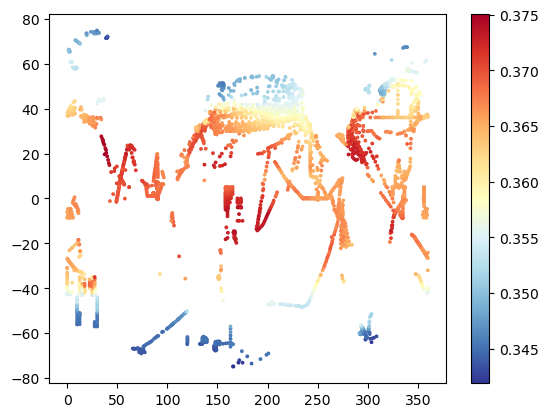

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5b8bfa6b80>

In [134]:

datasel = findall(obsdepth .< 300)
scat = plt.scatter(obslon[datasel], obslat[datasel], s=3, c=obsval[datasel], cmap=plt.cm.RdYlBu_r)
plt.colorbar(scat)

In [63]:
length(lon), size(dohc)

(8781, (3, 8781))

In [89]:
timeperiodtest = 1990:2002
datafilelist = ME4OH.get_filelist(datadir, timeperiodtest);

In [94]:
obslonall = Float32[]
obslatall = Float32[]
obsdepthall = Float32[]
obsdatesall = DateTime[]
Tall = Float32[]
Sall = Float32[]

for datafile in datafilelist
    lon, lat, dates, depth, T, S, dohc = ME4OH.read_profile(datafile)
    lon[lon .< 20.] .+= 360;
    obslon, obslat, obsdates, obsdepth, T, S = ME4OH.vectorize_obs(lon, lat, dates, depth, T, S);
    
    append!(obslonall, obslon)
    append!(obslatall, obslat)
    append!(obsdepthall, obsdepth)
    append!(obsdatesall, obsdates)
    append!(Tall, T)
    append!(Sall, S)
end

## Create grid
### Longitude / latitude
Defined in the file `config.jl`
### Depth levels
Read from the first file

In [73]:
_, _, _, depthgrid, _, _, _ = ME4OH.read_profile(datafilelist[1]);
depthgrid;

### Time periods

In [75]:
TS = TimeSelectorYearListMonthList([yy:yy for yy in timeperiodtest], [ii:ii for ii in 1:12]);
length(TS)

156

## Run analysis
### Set analysis parameters

In [76]:
sz = (length(longrid), length(latgrid), length(depthgrid))

lenx = fill(160_000., sz)
leny = fill(160_000., sz)
lenz = fill(0., sz);
epsilon2 = 5.

5.0

In [77]:
TS

TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{UnitRange{Int64}}}(UnitRange{Int64}[1990:1990, 1991:1991, 1992:1992, 1993:1993, 1994:1994, 1995:1995, 1996:1996, 1997:1997, 1998:1998, 1999:1999, 2000:2000, 2001:2001, 2002:2002], UnitRange{Int64}[1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 11:11, 12:12])

In [99]:
obslonall, obslatall, obsdepthall = Float64.(obslonall), Float64.(obslatall), Float64.(obsdepthall)
Tall = Float64.(Tall);

In [ ]:
@time dbinfo = diva3d((longrid, latgrid, depthgrid, TS),
              (obslonall, obslatall, obsdepthall, obsdatesall),
              Tall,
              (lenx,leny,lenz),
              epsilon2,
              joinpath(outputdir, "diva3d2delete.nc"), "Temperature",
              bathname = "../data/gebco_30sec_16.nc",
              bathisglobal = true,
              #timeorigin = DateTime(1900,1,1,0,0,0),
       );

[ Info: Creating netCDF file ../output/diva3d2delete.nc
[ Info: Time step 1 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 2 

[ Info: Time step 8 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 9 / 156
[ Info: scaled correlation length (min,max) in dim

[ Info: Time step 15 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 16 / 156
[ Info: scaled correlation length (min,max) in d

[ Info: Time step 22 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 23 / 156
[ Info: scaled correlation length (min,max) in d

[ Info: Time step 29 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 30 / 156
[ Info: scaled correlation length (min,max) in d

[ Info: number of windows: 48
[ Info: Time step 36 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 37 / 156
[ Info: scaled cor

[ Info: number of windows: 48
[ Info: Time step 43 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 44 / 156
[ Info: scaled cor

[ Info: Time step 50 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 51 / 156
[ Info: scaled correlation length (min,max) in d

[ Info: Time step 57 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 58 / 156
[ Info: scaled correlation length (min,max) in d

[ Info: Time step 64 / 156
[ Info: scaled correlation length (min,max) in dimension 1: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (160000.0, 160000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (0.0, 0.0)
┌ Warning: resolution (80657.57882672557) is too coarse for correlation length 160000.0 in dimension 1 at indices CartesianIndex(1, 47, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
┌ Warning: resolution (111195.08372418846) is too coarse for correlation length 160000.0 in dimension 2 at indices CartesianIndex(171, 12, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 48
[ Info: Time step 65 / 156
[ Info: scaled correlation length (min,max) in d